In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

SPX_Constituents processing:

In [2]:
spx_constituents = pd.read_csv("Data/SPX_const_data.csv",index_col=0)
spx_constituents.index.name = "Date"
spx_constituents.index = pd.to_datetime(spx_constituents.index)
spx_constituents_prices= spx_constituents[[col for col in spx_constituents.columns if "price" in col]]
spx_constituents_returns = spx_constituents_prices.pct_change()
spx_constituents_returns = spx_constituents_returns[1:]

SPX_Index Processing:

In [3]:
spx = yf.Ticker("^GSPC")
spx_prices = spx.history(start="2014-12-31", end="2025-01-29")["Close"]
spx_returns = spx_prices.pct_change()
spx_returns = spx_returns[1:]

Beta Calculation:

In [4]:
spx_constituents_returns.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2025-01-16', '2025-01-17', '2025-01-20', '2025-01-21',
               '2025-01-22', '2025-01-23', '2025-01-24', '2025-01-27',
               '2025-01-28', '2025-01-29'],
              dtype='datetime64[ns]', name='Date', length=2629, freq=None)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

Skipping DPZ_price due to no overlapping data with index
Skipping MRP-W_price due to no overlapping data with index
Top 10 highest beta stocks:
          Beta
CHD   0.393575
CAG   0.361358
EVRG  0.360765
HRL   0.332527
SJM   0.304834
K     0.302264
GIS   0.297420
CLX   0.288502
KR    0.277803
CPB   0.008546

Top 10 lowest beta stocks:
          Beta
PLTR  2.405481
CZR   2.092304
GEV   2.004919
NCLH  1.895776
CCL   1.868444
ON    1.781859
MPWR  1.753480
RCL   1.691207
LRCX  1.677675
AMAT  1.641983

Beta statistics:
             Beta
count  494.000000
mean     0.990508
std      0.304813
min      0.008546
25%      0.794322
50%      0.988663
75%      1.173880
max      2.405481


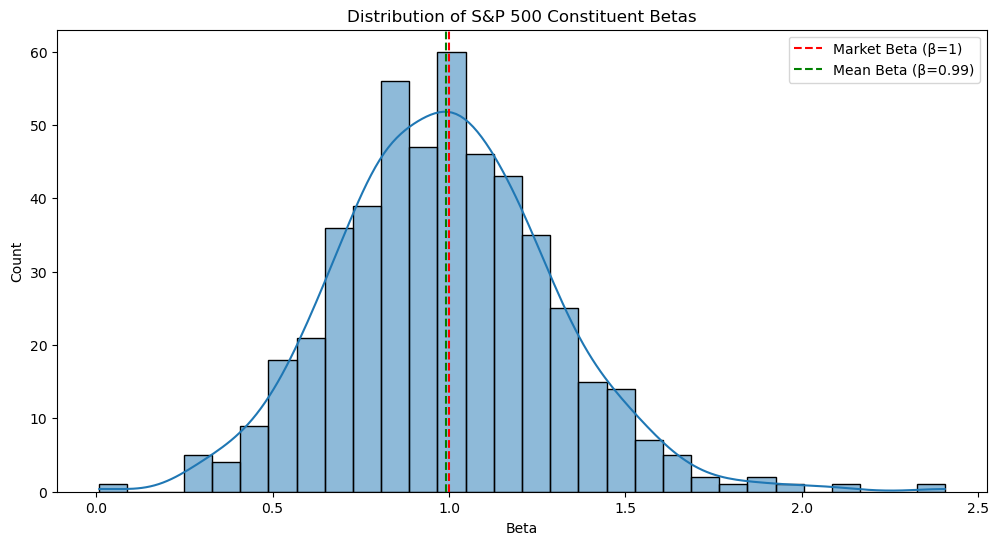

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timezone differences
if hasattr(spx_returns.index, 'tzinfo') and spx_returns.index.tzinfo is not None:
    spx_returns = spx_returns.tz_localize(None)
if hasattr(spx_constituents_returns.index, 'tzinfo') and spx_constituents_returns.index.tzinfo is not None:
    spx_constituents_returns = spx_constituents_returns.tz_localize(None)

# Align data by datetime index
aligned_data = pd.concat([spx_returns, spx_constituents_returns], axis=1)
aligned_data.columns = ['SPX'] + list(spx_constituents_returns.columns)
#Lets do first the beta for 5 years with no clustering:

aligned_data = aligned_data["2019":"2024"]

# Calculate beta for each stock
betas = {}
for column in spx_constituents_returns.columns:
    # Extract data and handle missing values properly
    stock_data = aligned_data[['SPX', column]].copy()
    stock_data.dropna(inplace=True)
    
    if len(stock_data) < 30:  # Ensure minimum sample size for reliable beta
        print(f"Warning: {column} has fewer than 30 data points after dropping NAs")
        if len(stock_data) == 0:
            print(f"Skipping {column} due to no overlapping data with index")
            continue
    
    # Calculate beta
    stock_returns = stock_data[column]
    market_returns = stock_data['SPX']
    
    # Calculate covariance between stock and market
    covariance = np.cov(stock_returns, market_returns)[0, 1]
    
    # Calculate variance of market
    market_variance = np.var(market_returns)
    
    # Calculate beta
    beta = covariance / market_variance
    
    # Extract ticker symbol from column name
    ticker = column.split('_')[0]
    betas[ticker] = beta

# Convert to DataFrame for analysis
beta_df = pd.DataFrame.from_dict(betas, orient='index', columns=['Beta'])
beta_df = beta_df.sort_values('Beta',ascending = False)

# Display the top 10 highest and lowest beta stocks
print("Top 10 highest beta stocks:")
print(beta_df.tail(10))
print("\nTop 10 lowest beta stocks:")
print(beta_df.head(10))

# Calculate basic statistics
print("\nBeta statistics:")
print(beta_df.describe())

# Alternative method using linear regression
regression_betas = {}
for column in spx_constituents_returns.columns:
    # Extract data and handle missing values
    stock_data = aligned_data[['SPX', column]].copy()
    stock_data.dropna(inplace=True)
    
    if len(stock_data) < 30:
        if len(stock_data) == 0:
            continue
    
    # Prepare data for regression
    X = stock_data['SPX'].values.reshape(-1, 1)
    y = stock_data[column].values
    
    # Fit linear regression model
    from sklearn.linear_model import LinearRegression
    model = LinearRegression().fit(X, y)
    
    # Extract beta (slope coefficient)
    ticker = column.split('_')[0]
    regression_betas[ticker] = model.coef_[0]

# Convert regression betas to DataFrame
regression_beta_df = pd.DataFrame.from_dict(regression_betas, orient='index', columns=['Beta'])
regression_beta_df = regression_beta_df.sort_values('Beta',ascending = False)

# Plot histogram of betas
plt.figure(figsize=(12, 6))
sns.histplot(beta_df['Beta'], bins=30, kde=True)
plt.title('Distribution of S&P 500 Constituent Betas')
plt.xlabel('Beta')
plt.axvline(x=1, color='red', linestyle='--', label='Market Beta (β=1)')
plt.axvline(x=beta_df['Beta'].mean(), color='green', linestyle='--', label=f'Mean Beta (β={beta_df["Beta"].mean():.2f})')
plt.legend()

# Compare two methods (optional)
beta_comparison = pd.DataFrame({
    'Cov/Var Beta': beta_df['Beta'],
    'Regression Beta': regression_beta_df['Beta']
})



Do the same with the small caps:


In [7]:
russ_2000_tickers = pd.read_excel("Data\RTY as of Feb 27 20251.xlsx")["Ticker"].tolist()

In [8]:
russ_2000_tickers = [tick.split(" ")[0] for tick in russ_2000_tickers]


In [9]:
russ_2000_data = yf.download(russ_2000_tickers, start="2014-12-31", end="2025-01-29")["Close"]

[                       0%                       ]

YF.download() has changed argument auto_adjust default to True


[                       1%                       ]  14 of 1951 completedFailed to get ticker 'GEF/B' reason: Expecting value: line 1 column 1 (char 0)
[************          24%                       ]  477 of 1951 completedCould not get exchangeTimezoneName for ticker 'CVLG' reason: 'chart'
[***************       31%                       ]  596 of 1951 completedFailed to get ticker 'LGF/B' reason: Expecting value: line 1 column 1 (char 0)
[********************  41%                       ]  801 of 1951 completedFailed to get ticker 'CRD/A' reason: Expecting value: line 1 column 1 (char 0)
[**********************53%                       ]  1039 of 1951 completedFailed to get ticker 'UNTY' reason: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)
[**********************81%**************         ]  1583 of 1951 completedFailed to get ticker 'MOG/A' reason: Expecting value: line 1 column 1 (char 0)
[**********************89%****************

In [10]:
russ_2000_returns = russ_2000_data.pct_change()
russ_2000_returns = russ_2000_returns[1:]

Skipping ABCB due to no overlapping data with index
Skipping ABSI due to no overlapping data with index
Skipping ACA due to no overlapping data with index
Skipping ACCD due to no overlapping data with index
Skipping AEVA due to no overlapping data with index
Skipping AGL due to no overlapping data with index
Skipping AKYA due to no overlapping data with index
Skipping ALEC due to no overlapping data with index
Skipping ALEX due to no overlapping data with index
Skipping ALGT due to no overlapping data with index
Skipping AMN due to no overlapping data with index
Skipping AMRK due to no overlapping data with index
Skipping ANIK due to no overlapping data with index
Skipping AORT due to no overlapping data with index
Skipping APLT due to no overlapping data with index
Skipping APOG due to no overlapping data with index
Skipping ARDT due to no overlapping data with index
Skipping ARDX due to no overlapping data with index
Skipping ASIX due to no overlapping data with index
Skipping ASTE d

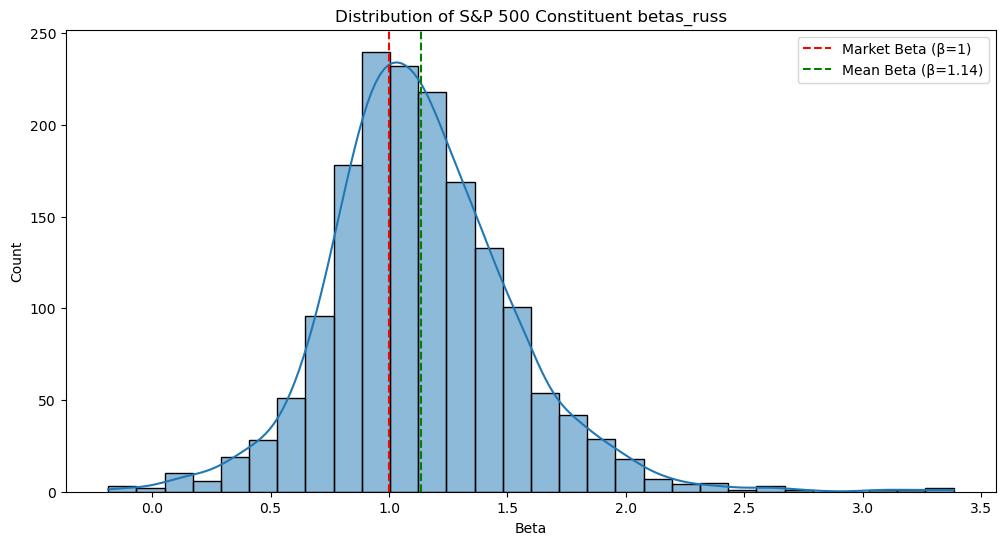

In [23]:
# Handle timezone differences
if hasattr(spx_returns.index, 'tzinfo') and spx_returns.index.tzinfo is not None:
    spx_returns = spx_returns.tz_localize(None)
if hasattr(russ_2000_returns.index, 'tzinfo') and russ_2000_returns.index.tzinfo is not None:
    russ_2000_returns = russ_2000_returns.tz_localize(None)

# Align data by datetime index
aligned_data = pd.concat([spx_returns, russ_2000_returns], axis=1)
aligned_data.columns = ['SPX'] + list(russ_2000_returns.columns)
#Lets do first the beta for 5 years with no clustering:

aligned_data = aligned_data["2019":"2024"]
a = 0
# Calculate beta for each stock
betas_russ = {}
for column in russ_2000_returns.columns:
    # Extract data and handle missing values properly
    stock_data = aligned_data[['SPX', column]].copy()
    stock_data.dropna(inplace=True)
    
    if len(stock_data) < 30:  # Ensure minimum sample size for reliable beta
        print(f"Warning: {column} has fewer than 30 data points after dropping NAs")
        a+=1
        if len(stock_data) == 0:
            print(f"Skipping {column} due to no overlapping data with index")
            continue
    
    # Calculate beta
    stock_returns = stock_data[column]
    market_returns = stock_data['SPX']
    
    # Calculate covariance between stock and market
    covariance = np.cov(stock_returns, market_returns)[0, 1]
    
    # Calculate variance of market
    market_variance = np.var(market_returns)
    
    # Calculate beta
    beta = covariance / market_variance
    
    # Extract ticker symbol from column name
    ticker = column.split('_')[0]
    betas_russ[ticker] = beta

# Convert to DataFrame for analysis
beta_df_russ = pd.DataFrame.from_dict(betas_russ, orient='index', columns=['Beta'])
beta_df_russ = beta_df_russ.sort_values('Beta',ascending = False)

# Display the top 10 highest and lowest beta stocks
print("Top 10 highest beta stocks:")
print(beta_df_russ.tail(10))
print("\nTop 10 lowest beta stocks:")
print(beta_df_russ.head(10))

# Calculate basic statistics
print("\nBeta statistics:")
print(beta_df_russ.describe())

# Alternative method using linear regression
regression_betas_russ = {}
for column in russ_2000_returns.columns:
    # Extract data and handle missing values
    stock_data = aligned_data[['SPX', column]].copy()
    stock_data.dropna(inplace=True)
    
    if len(stock_data) < 30:
        if len(stock_data) == 0:
            continue
    
    # Prepare data for regression
    X = stock_data['SPX'].values.reshape(-1, 1)
    y = stock_data[column].values
    
    # Fit linear regression model
    from sklearn.linear_model import LinearRegression
    model = LinearRegression().fit(X, y)
    
    # Extract beta (slope coefficient)
    ticker = column.split('_')[0]
    regression_betas_russ[ticker] = model.coef_[0]

# Convert regression betas_russ to DataFrame
regression_beta_df_russ = pd.DataFrame.from_dict(regression_betas_russ, orient='index', columns=['Beta'])
regression_beta_df_russ = regression_beta_df_russ.sort_values('Beta')

# Plot histogram of betas_russ
plt.figure(figsize=(12, 6))
sns.histplot(beta_df_russ['Beta'], bins=30, kde=True)
plt.title('Distribution of S&P 500 Constituent betas_russ')
plt.xlabel('Beta')
plt.axvline(x=1, color='red', linestyle='--', label='Market Beta (β=1)')
plt.axvline(x=beta_df_russ['Beta'].mean(), color='green', linestyle='--', label=f'Mean Beta (β={beta_df_russ["Beta"].mean():.2f})')
plt.legend()

# Compare two methods (optional)
beta_comparison_russ = pd.DataFrame({
    'Cov/Var Beta': beta_df_russ['Beta'],
    'Regression Beta': regression_beta_df_russ['Beta']
})


In [12]:
top_200_betas_russ = beta_df_russ.head(100)
top_50_betas_SP=beta_df.head(25)

In [24]:
print(a)

297


In [13]:
top_50_betas_returns = spx_constituents_returns[[col for col in spx_constituents_returns.columns if col.split("_")[0] in top_50_betas_SP.index]]
top_200_betas_russ_returns = russ_2000_returns[[col for col in russ_2000_returns.columns if col in top_200_betas_russ.index]]
top_50_betas_returns = top_50_betas_returns["2024":"2025"]
top_200_betas_russ_returns = top_200_betas_russ_returns["2024":"2025"]
sp_weights = top_50_betas_SP / top_50_betas_SP.sum()
russ_weights = top_200_betas_russ / top_200_betas_russ.sum()
# Create empty DataFrames to store the portfolio returns
sp_beta_weighted_portfolio = pd.DataFrame(index=top_50_betas_returns.index)
russ_beta_weighted_portfolio = pd.DataFrame(index=top_200_betas_russ_returns.index)

# Calculate the beta-weighted portfolio returns for S&P 500
weighted_returns_sp = pd.DataFrame(index=top_50_betas_returns.index)
for ticker in top_50_betas_SP.index:
    ticker_cols = [col for col in top_50_betas_returns.columns if col.split("_")[0] == ticker]
    if ticker_cols:
        # For each ticker, weight its returns by its beta weight
        ticker_weight = sp_weights.loc[ticker]
        print(ticker_weight)
        for col in ticker_cols:
            weighted_returns_sp[col] = top_50_betas_returns[col] * ticker_weight["Beta"]
            print(weighted_returns_sp[col])

# Sum across all weighted returns to get the portfolio return
sp_beta_weighted_portfolio['returns'] = weighted_returns_sp.sum(axis=1)

# Calculate the beta-weighted portfolio returns for Russell 2000
weighted_returns_russ = pd.DataFrame(index=top_200_betas_russ_returns.index)
for ticker in top_200_betas_russ.index:
    # Check if the ticker exists in the returns dataframe
    if ticker in top_200_betas_russ_returns.columns:
        # Weight the returns by the beta weight
        ticker_weight = russ_weights.loc[ticker]
        weighted_returns_russ[ticker] = top_200_betas_russ_returns[ticker] * ticker_weight["Beta"]

# Sum across all weighted returns to get the portfolio return
russ_beta_weighted_portfolio['returns'] = weighted_returns_russ.sum(axis=1)


Beta    0.057092
Name: PLTR, dtype: float64
Date
2024-01-01         NaN
2024-01-02         NaN
2024-01-03         NaN
2024-01-04         NaN
2024-01-05         NaN
                ...   
2025-01-23    0.001567
2025-01-24    0.000000
2025-01-27   -0.002559
2025-01-28    0.003625
2025-01-29   -0.001003
Name: PLTR_price, Length: 283, dtype: float64
Beta    0.049659
Name: CZR, dtype: float64
Date
2024-01-01    0.000000
2024-01-02    0.000953
2024-01-03   -0.002889
2024-01-04   -0.000099
2024-01-05    0.000000
                ...   
2025-01-23    0.000574
2025-01-24    0.000640
2025-01-27    0.000617
2025-01-28    0.001021
2025-01-29   -0.000042
Name: CZR_price, Length: 283, dtype: float64
Beta    0.047585
Name: GEV, dtype: float64
Date
2024-01-01         NaN
2024-01-02         NaN
2024-01-03         NaN
2024-01-04         NaN
2024-01-05         NaN
                ...   
2025-01-23    0.001182
2025-01-24   -0.001872
2025-01-27   -0.010240
2025-01-28    0.003622
2025-01-29   -0.000181
Name:

In [14]:
sp_beta_weighted_portfolio

returns
Date                
2024-01-01  0.000000
2024-01-02 -0.025083
2024-01-03 -0.027180
2024-01-04 -0.003040
2024-01-05  0.006013
...              ...
2025-01-23  0.007501
2025-01-24 -0.015494
2025-01-27 -0.025702
2025-01-28  0.020609
2025-01-29  0.002898

[283 rows x 1 columns]

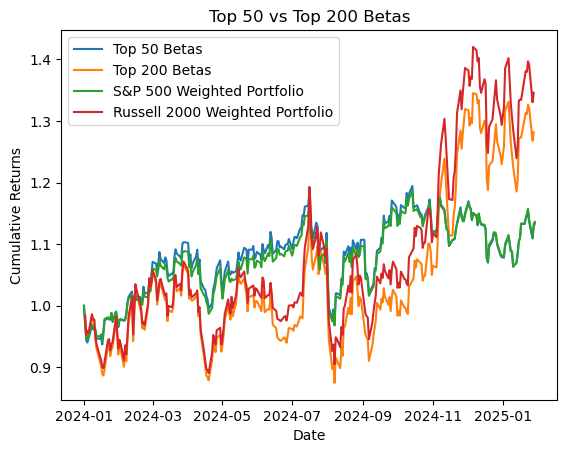

In [15]:
mean_returns_top_200 = top_200_betas_russ_returns.mean(axis = 1)
cum_returns_top_200 = (1 + mean_returns_top_200).cumprod()
mean_returns_top_50 = top_50_betas_returns.mean(axis = 1)
cum_returns_top_50 = (1 + mean_returns_top_50).cumprod()
cum_returns_sp_weighted = (1 + sp_beta_weighted_portfolio['returns']).cumprod()
cum_returns_russ_weighted = (1 + russ_beta_weighted_portfolio['returns']).cumprod()
plt.plot(cum_returns_top_50, label="Top 50 Betas")
plt.plot(cum_returns_top_200, label="Top 200 Betas")
plt.plot(cum_returns_sp_weighted, label="S&P 500 Weighted Portfolio")
plt.plot(cum_returns_russ_weighted, label="Russell 2000 Weighted Portfolio")
plt.title("Top 50 vs Top 200 Betas")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()


In [16]:
strategy_1 = mean_returns_top_200-mean_returns_top_50
strategy_2 = russ_beta_weighted_portfolio['returns'] - sp_beta_weighted_portfolio['returns']
strategy_cumulative_returns_1 = (1 + strategy_1).cumprod()
strategy_cumulative_returns_2 = (1 + strategy_2).cumprod()
plt.plot(strategy_cumulative_returns_1, label="Strategy 1")
plt.plot(strategy_cumulative_returns_2, label="Strategy 2")
plt.title("Strategy 1 vs Strategy 2")   
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.show()
print(f"Mean Annualized Returns for Strategy 1: {strategy_1.mean()*252}")
print(f"Mean Annualized Returns for Strategy 2: {strategy_2.mean()*252}")
print(f"Standard Deviation for Strategy 1: {strategy_1.std()*np.sqrt(252)}")
print(f"Standard Deviation for Strategy 2: {strategy_2.std()*np.sqrt(252)}")
# Calculate the Sharpe Ratio for both strategies
sharpe_ratio_1 = strategy_1.mean() / strategy_1.std()
sharpe_ratio_2 = strategy_2.mean() / strategy_2.std()
print(f"Sharpe Ratio for Strategy 1: {sharpe_ratio_1*np.sqrt(252)}")
print(f"Sharpe Ratio for Strategy 2: {sharpe_ratio_2*np.sqrt(252)}")


Mean Annualized Returns for Strategy 1: 0.1608186850740913
Mean Annualized Returns for Strategy 2: 0.2029794032634583
Standard Deviation for Strategy 1: 0.2633443640389639
Standard Deviation for Strategy 2: 0.2592223000300349
Sharpe Ratio for Strategy 1: 0.6106782868164853
Sharpe Ratio for Strategy 2: 0.7830321821847119


In [17]:
import scipy.stats as stats

# For strategy_1
n_1 = len(strategy_1)  # Number of observations
sharpe_ratio_1 = strategy_1.mean() / strategy_1.std()
# The t-statistic when testing if Sharpe = 0
t_stat_1 = sharpe_ratio_1 * np.sqrt(n_1)
# P-value (two-tailed test)
p_value_1 = 2 * (1 - stats.t.cdf(abs(t_stat_1), df=n_1-1))

# For strategy_2
n_2 = len(strategy_2)  # Number of observations
sharpe_ratio_2 = strategy_2.mean() / strategy_2.std()
# The t-statistic when testing if Sharpe = 0
t_stat_2 = sharpe_ratio_2 * np.sqrt(n_2)
# P-value (two-tailed test)
p_value_2 = 2 * (1 - stats.t.cdf(abs(t_stat_2), df=n_2-1))

print(f"Strategy 1 - Sharpe: {sharpe_ratio_1:.4f}, t-stat: {t_stat_1:.4f}, p-value: {p_value_1:.4f}")
print(f"Strategy 2 - Sharpe: {sharpe_ratio_2:.4f}, t-stat: {t_stat_2:.4f}, p-value: {p_value_2:.4f}")

Strategy 1 - Sharpe: 0.0385, t-stat: 0.6472, p-value: 0.5181
Strategy 2 - Sharpe: 0.0493, t-stat: 0.8298, p-value: 0.4074


In [27]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def optimize_ratio(ratio):
    """
    Calculates strategy_2 returns based on the given ratio parameter.
    This is your original function.
    """
    top_200_betas_russ = beta_df_russ.head(int(ratio*2000))
    top_50_betas_SP = beta_df.head(int(ratio*500))
    top_50_betas_returns = spx_constituents_returns[[col for col in spx_constituents_returns.columns if col.split("_")[0] in top_50_betas_SP.index]]
    top_200_betas_russ_returns = russ_2000_returns[[col for col in russ_2000_returns.columns if col in top_200_betas_russ.index]]
    top_50_betas_returns = top_50_betas_returns["2024":"2025"]
    top_200_betas_russ_returns = top_200_betas_russ_returns["2024":"2025"]
    sp_weights = top_50_betas_SP / top_50_betas_SP.sum()
    russ_weights = top_200_betas_russ / top_200_betas_russ.sum()
    
    # Create empty DataFrames to store the portfolio returns
    sp_beta_weighted_portfolio = pd.DataFrame(index=top_50_betas_returns.index)
    russ_beta_weighted_portfolio = pd.DataFrame(index=top_200_betas_russ_returns.index)

    # Calculate the beta-weighted portfolio returns for S&P 500
    weighted_returns_sp = pd.DataFrame(index=top_50_betas_returns.index)
    for ticker in top_50_betas_SP.index:
        ticker_cols = [col for col in top_50_betas_returns.columns if col.split("_")[0] == ticker]
        if ticker_cols:
            # For each ticker, weight its returns by its beta weight
            ticker_weight = sp_weights.loc[ticker]
            for col in ticker_cols:
                weighted_returns_sp[col] = top_50_betas_returns[col] * ticker_weight["Beta"]

    # Sum across all weighted returns to get the portfolio return
    sp_beta_weighted_portfolio['returns'] = weighted_returns_sp.sum(axis=1)

    # Calculate the beta-weighted portfolio returns for Russell 2000
    weighted_returns_russ = pd.DataFrame(index=top_200_betas_russ_returns.index)
    for ticker in top_200_betas_russ.index:
        # Check if the ticker exists in the returns dataframe
        if ticker in top_200_betas_russ_returns.columns:
            # Weight the returns by the beta weight
            ticker_weight = russ_weights.loc[ticker]
            weighted_returns_russ[ticker] = top_200_betas_russ_returns[ticker] * ticker_weight["Beta"]

    # Sum across all weighted returns to get the portfolio return
    russ_beta_weighted_portfolio['returns'] = weighted_returns_russ.sum(axis=1)
    strategy_2 = russ_beta_weighted_portfolio['returns'] - sp_beta_weighted_portfolio['returns']

    return strategy_2

def find_optimal_ratio():
    """
    Find the optimal ratio that maximizes the cumulative return of strategy_2.
    Uses a grid search approach to evaluate different ratios.
    """
    # Define the range of ratios to test
    start_ratio = 0.0
    end_ratio = 0.2
    step = 0.01
    
    ratios = np.arange(start_ratio, end_ratio + step, step)
    results = []
    
    # Evaluate each ratio
    for ratio in tqdm(ratios, desc="Testing ratios"):
        try:
            # Get strategy returns for this ratio
            strategy_returns = optimize_ratio(ratio)
            
            # Calculate cumulative return
            cumulative_return = (1 + strategy_returns).prod() - 1
            
            # Calculate other metrics
            sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized Sharpe
            max_drawdown = calculate_max_drawdown(strategy_returns)
            
            results.append({
                'ratio': ratio,
                'cumulative_return': cumulative_return,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown
            })
            
        except Exception as e:
            print(f"Error evaluating ratio {ratio}: {e}")
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Find the ratio with the highest cumulative return
    best_return_ratio = results_df.loc[results_df['cumulative_return'].idxmax()]
    
    # Find the ratio with the best risk-adjusted return (Sharpe)
    best_sharpe_ratio = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    
    print(f"Best ratio by return: {best_return_ratio['ratio']} with cumulative return of {best_return_ratio['cumulative_return']:.4f}")
    print(f"Best ratio by Sharpe: {best_sharpe_ratio['ratio']} with Sharpe ratio of {best_sharpe_ratio['sharpe_ratio']:.4f}")
    
    # Plot the results
    plot_optimization_results(results_df)
    
    return results_df

def calculate_max_drawdown(returns):
    """Calculate the maximum drawdown from a series of returns."""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative / running_max) - 1
    return drawdown.min()

def plot_optimization_results(results_df):
    """Plot the optimization results to visualize the optimal ratio."""
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot cumulative return
    ax1.plot(results_df['ratio'], results_df['cumulative_return'], 'b-', label='Cumulative Return')
    ax1.set_xlabel('Ratio')
    ax1.set_ylabel('Cumulative Return', color='b')
    ax1.tick_params('y', colors='b')
    
    # Highlight the best ratio
    best_ratio = results_df.loc[results_df['cumulative_return'].idxmax(), 'ratio']
    best_return = results_df.loc[results_df['cumulative_return'].idxmax(), 'cumulative_return']
    ax1.scatter(best_ratio, best_return, color='b', s=100, zorder=5)
    ax1.annotate(f'Best: {best_ratio:.2f}',
                xy=(best_ratio, best_return),
                xytext=(best_ratio+0.01, best_return),
                arrowprops=dict(facecolor='black', width=1, headwidth=6),
                fontsize=12)
    
    # Add Sharpe ratio on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(results_df['ratio'], results_df['sharpe_ratio'], 'r--', label='Sharpe Ratio')
    ax2.set_ylabel('Sharpe Ratio', color='r')
    ax2.tick_params('y', colors='r')
    
    # Add maximum drawdown on the same secondary y-axis
    ax2.plot(results_df['ratio'], results_df['max_drawdown'], 'g-.', label='Max Drawdown')
    
    # Add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title('Strategy Performance Metrics by Ratio')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Testing ratios:   0%|          | 0/21 [00:00<?, ?it/s]C:\Users\Usuario1\AppData\Local\Temp\ipykernel_7800\4170733960.py:75: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized Sharpe
Testing ratios:  29%|██▊       | 6/21 [00:00<00:01,  9.01it/s]C:\Users\Usuario1\AppData\Local\Temp\ipykernel_7800\4170733960.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_returns_russ[ticker] = top_200_betas_russ_returns[ticker] * ticker_weight["Beta"]
C:\Users\Usuario1\AppData\Local\Temp\ipykernel_7800\4170733960.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

Best ratio by return: 0.01 with cumulative return of 0.3625
Best ratio by Sharpe: 0.03 with Sharpe ratio of 0.9617


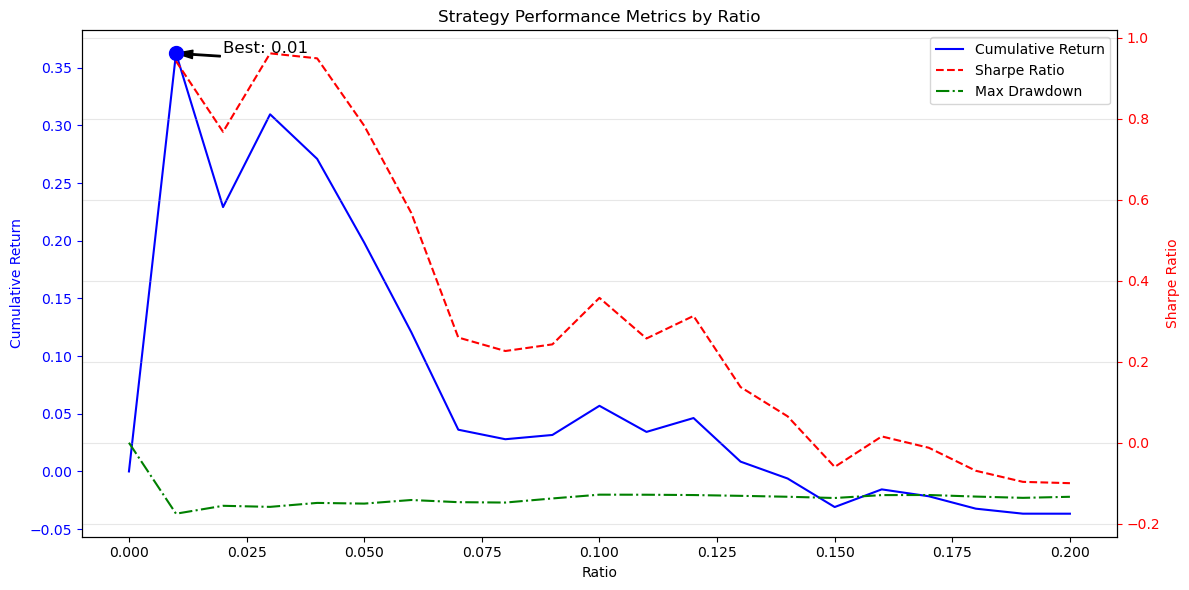

In [ ]:
results = find_optimal_ratio()
    
# You can also get the exact optimal ratio
optimal_ratio = results.loc[results['cumulative_return'].idxmax(), 'ratio']
print(f"Optimal ratio: {optimal_ratio}")

# Get the strategy returns with the optimal ratio
optimal_strategy = optimize_ratio(0.03)

# Plot the optimal strategy returns
plt.figure(figsize=(12, 6))
optimal_strategy.cumsum().plot(style="--")
plt.title(f'Strategy Performance with Optimal Ratio ({optimal_ratio:.2f})')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.show()

Testing ratios:   0%|          | 0/21 [00:00<?, ?it/s]C:\Users\Usuario1\AppData\Local\Temp\ipykernel_7800\2592667104.py:70: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized Sharpe
Testing ratios:  24%|██▍       | 5/21 [00:00<00:01, 10.03it/s]C:\Users\Usuario1\AppData\Local\Temp\ipykernel_7800\2592667104.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_returns_russ[ticker] = top_200_betas_russ_returns[ticker] * ticker_weight["Beta"]
C:\Users\Usuario1\AppData\Local\Temp\ipykernel_7800\2592667104.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

Best ratio by return: 0.01 with cumulative return of 0.3625
Best ratio by Sharpe: 0.03 with Sharpe ratio of 0.9617


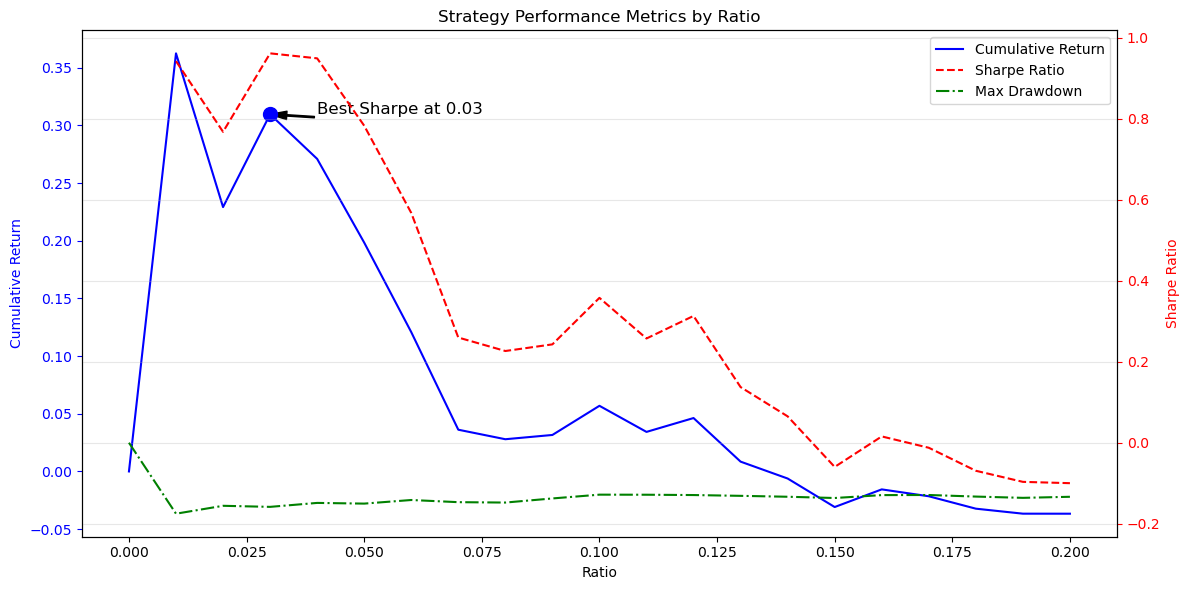

Optimal ratio for maximizing Sharpe: 0.03 (Sharpe: 0.9617)
Best ratio for return: 0.01 (Return: 0.3625)


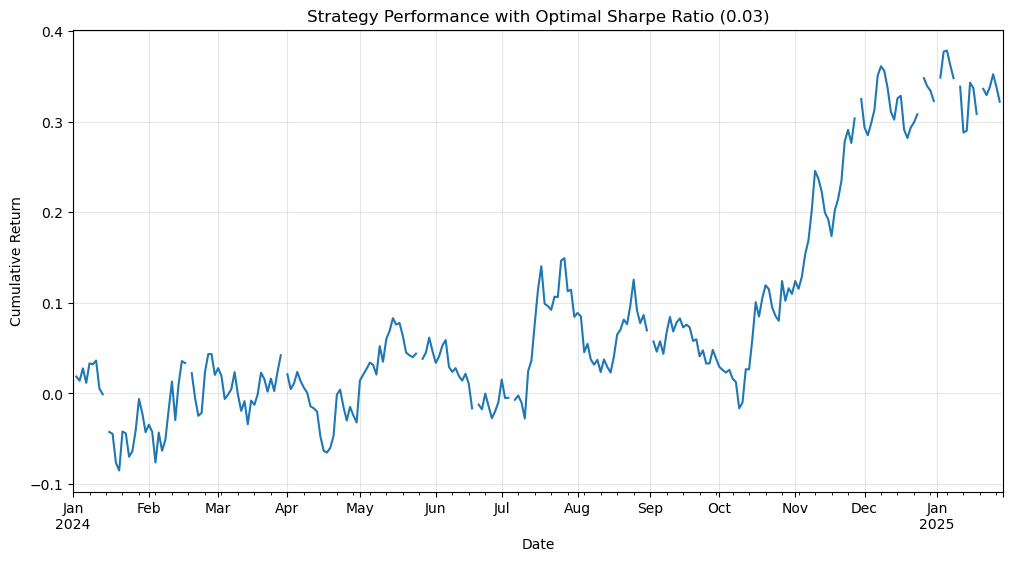


Strategy Performance with Optimal Ratio (0.03):
Annualized Sharpe Ratio: 0.9617
Annualized Return: 27.1538%
Maximum Drawdown: -15.8366%


In [30]:
def optimize_ratio(ratio):
    """
    Calculates strategy_2 returns based on the given ratio parameter.
    This is your original function.
    """
    top_200_betas_russ = beta_df_russ.head(int(ratio*2000))
    top_50_betas_SP = beta_df.head(int(ratio*500))
    top_50_betas_returns = spx_constituents_returns[[col for col in spx_constituents_returns.columns if col.split("_")[0] in top_50_betas_SP.index]]
    top_200_betas_russ_returns = russ_2000_returns[[col for col in russ_2000_returns.columns if col in top_200_betas_russ.index]]
    top_50_betas_returns = top_50_betas_returns["2024":"2025"]
    top_200_betas_russ_returns = top_200_betas_russ_returns["2024":"2025"]
    sp_weights = top_50_betas_SP / top_50_betas_SP.sum()
    russ_weights = top_200_betas_russ / top_200_betas_russ.sum()
    
    # Create empty DataFrames to store the portfolio returns
    sp_beta_weighted_portfolio = pd.DataFrame(index=top_50_betas_returns.index)
    russ_beta_weighted_portfolio = pd.DataFrame(index=top_200_betas_russ_returns.index)

    # Calculate the beta-weighted portfolio returns for S&P 500
    weighted_returns_sp = pd.DataFrame(index=top_50_betas_returns.index)
    for ticker in top_50_betas_SP.index:
        ticker_cols = [col for col in top_50_betas_returns.columns if col.split("_")[0] == ticker]
        if ticker_cols:
            # For each ticker, weight its returns by its beta weight
            ticker_weight = sp_weights.loc[ticker]
            for col in ticker_cols:
                weighted_returns_sp[col] = top_50_betas_returns[col] * ticker_weight["Beta"]

    # Sum across all weighted returns to get the portfolio return
    sp_beta_weighted_portfolio['returns'] = weighted_returns_sp.sum(axis=1)

    # Calculate the beta-weighted portfolio returns for Russell 2000
    weighted_returns_russ = pd.DataFrame(index=top_200_betas_russ_returns.index)
    for ticker in top_200_betas_russ.index:
        # Check if the ticker exists in the returns dataframe
        if ticker in top_200_betas_russ_returns.columns:
            # Weight the returns by the beta weight
            ticker_weight = russ_weights.loc[ticker]
            weighted_returns_russ[ticker] = top_200_betas_russ_returns[ticker] * ticker_weight["Beta"]

    # Sum across all weighted returns to get the portfolio return
    russ_beta_weighted_portfolio['returns'] = weighted_returns_russ.sum(axis=1)
    strategy_2 = russ_beta_weighted_portfolio['returns'] - sp_beta_weighted_portfolio['returns']

    return strategy_2

def find_optimal_ratio():
    """
    Find the optimal ratio that maximizes the Sharpe ratio of strategy_2.
    Uses a grid search approach to evaluate different ratios.
    """
    # Define the range of ratios to test
    start_ratio = 0.0
    end_ratio = 0.2
    step = 0.01
    
    ratios = np.arange(start_ratio, end_ratio + step, step)
    results = []
    
    # Evaluate each ratio
    for ratio in tqdm(ratios, desc="Testing ratios"):
        try:
            # Get strategy returns for this ratio
            strategy_returns = optimize_ratio(ratio)
            
            # Calculate cumulative return
            cumulative_return = (1 + strategy_returns).prod() - 1
            
            # Calculate other metrics
            sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized Sharpe
            max_drawdown = calculate_max_drawdown(strategy_returns)
            
            results.append({
                'ratio': ratio,
                'cumulative_return': cumulative_return,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown
            })
            
        except Exception as e:
            print(f"Error evaluating ratio {ratio}: {e}")
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Find the ratio with the highest cumulative return
    best_return_ratio = results_df.loc[results_df['cumulative_return'].idxmax()]
    
    # Find the ratio with the best risk-adjusted return (Sharpe)
    best_sharpe_ratio = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    
    print(f"Best ratio by return: {best_return_ratio['ratio']} with cumulative return of {best_return_ratio['cumulative_return']:.4f}")
    print(f"Best ratio by Sharpe: {best_sharpe_ratio['ratio']} with Sharpe ratio of {best_sharpe_ratio['sharpe_ratio']:.4f}")
    
    # Plot the results
    plot_optimization_results(results_df, optimize_for='sharpe')
    
    return results_df

def calculate_max_drawdown(returns):
    """Calculate the maximum drawdown from a series of returns."""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative / running_max) - 1
    return drawdown.min()

def plot_optimization_results(results_df, optimize_for='return'):
    """
    Plot the optimization results to visualize the optimal ratio.
    
    Parameters:
    - results_df: DataFrame containing the optimization results
    - optimize_for: 'return' to optimize for cumulative return, 'sharpe' to optimize for Sharpe ratio
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot cumulative return
    ax1.plot(results_df['ratio'], results_df['cumulative_return'], 'b-', label='Cumulative Return')
    ax1.set_xlabel('Ratio')
    ax1.set_ylabel('Cumulative Return', color='b')
    ax1.tick_params('y', colors='b')
    
    # Highlight the best ratio based on optimization target
    if optimize_for == 'sharpe':
        best_ratio = results_df.loc[results_df['sharpe_ratio'].idxmax(), 'ratio']
        best_return = results_df.loc[results_df['sharpe_ratio'].idxmax(), 'cumulative_return']
        best_sharpe = results_df.loc[results_df['sharpe_ratio'].idxmax(), 'sharpe_ratio']
        ax1.scatter(best_ratio, best_return, color='b', s=100, zorder=5)
        ax1.annotate(f'Best Sharpe at {best_ratio:.2f}',
                    xy=(best_ratio, best_return),
                    xytext=(best_ratio+0.01, best_return),
                    arrowprops=dict(facecolor='black', width=1, headwidth=6),
                    fontsize=12)
    else:
        best_ratio = results_df.loc[results_df['cumulative_return'].idxmax(), 'ratio']
        best_return = results_df.loc[results_df['cumulative_return'].idxmax(), 'cumulative_return']
        ax1.scatter(best_ratio, best_return, color='b', s=100, zorder=5)
        ax1.annotate(f'Best Return at {best_ratio:.2f}',
                    xy=(best_ratio, best_return),
                    xytext=(best_ratio+0.01, best_return),
                    arrowprops=dict(facecolor='black', width=1, headwidth=6),
                    fontsize=12)
    
    # Add Sharpe ratio on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(results_df['ratio'], results_df['sharpe_ratio'], 'r--', label='Sharpe Ratio')
    ax2.set_ylabel('Sharpe Ratio', color='r')
    ax2.tick_params('y', colors='r')
    
    # Add maximum drawdown on the same secondary y-axis
    ax2.plot(results_df['ratio'], results_df['max_drawdown'], 'g-.', label='Max Drawdown')
    
    # Add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title('Strategy Performance Metrics by Ratio')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

results = find_optimal_ratio()

# Get the exact optimal ratio based on Sharpe ratio
optimal_ratio = results.loc[results['sharpe_ratio'].idxmax(), 'ratio']
optimal_sharpe = results.loc[results['sharpe_ratio'].idxmax(), 'sharpe_ratio']
print(f"Optimal ratio for maximizing Sharpe: {optimal_ratio} (Sharpe: {optimal_sharpe:.4f})")

# Also show the ratio that would maximize cumulative return for comparison
best_return_ratio = results.loc[results['cumulative_return'].idxmax(), 'ratio']
best_return = results.loc[results['cumulative_return'].idxmax(), 'cumulative_return']
print(f"Best ratio for return: {best_return_ratio} (Return: {best_return:.4f})")

# Get the strategy returns with the optimal Sharpe ratio
optimal_strategy = optimize_ratio(optimal_ratio)

# Plot the optimal strategy returns
plt.figure(figsize=(12, 6))
optimal_strategy.cumsum().plot()
plt.title(f'Strategy Performance with Optimal Sharpe Ratio ({optimal_ratio:.2f})')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print additional performance metrics for the optimal strategy
ann_sharpe = optimal_strategy.mean() / optimal_strategy.std() * np.sqrt(252)
ann_return = (1 + optimal_strategy).prod() ** (252 / len(optimal_strategy)) - 1
max_dd = calculate_max_drawdown(optimal_strategy)

print(f"\nStrategy Performance with Optimal Ratio ({optimal_ratio:.2f}):")
print(f"Annualized Sharpe Ratio: {ann_sharpe:.4f}")
print(f"Annualized Return: {ann_return:.4%}")
print(f"Maximum Drawdown: {max_dd:.4%}")

Testing ratios:   0%|          | 0/21 [00:00<?, ?it/s]C:\Users\Usuario1\AppData\Local\Temp\ipykernel_7800\3838961846.py:103: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized Sharpe
Testing ratios:  29%|██▊       | 6/21 [00:00<00:02,  7.26it/s]C:\Users\Usuario1\AppData\Local\Temp\ipykernel_7800\3838961846.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weighted_returns_russ[ticker] = top_200_betas_russ_returns[ticker] * ticker_weight["Beta"]
C:\Users\Usuario1\AppData\Local\Temp\ipykernel_7800\3838961846.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

Best ratio by return: 0.01 with cumulative return of 0.3625
Best ratio by Sharpe: 0.03 with Sharpe ratio of 0.9617


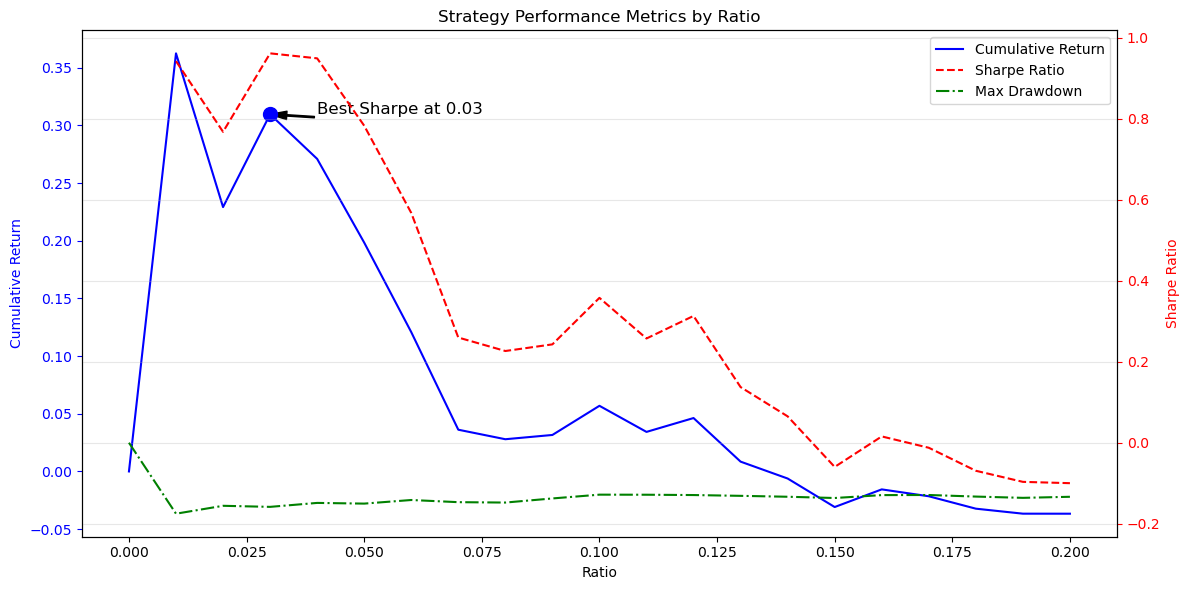

Optimal ratio for maximizing Sharpe: 0.03 (Sharpe: 0.9617)
Best ratio for return: 0.01 (Return: 0.3625)



Original Strategy Performance with Optimal Ratio (0.03):
Annualized Sharpe Ratio: 0.9617
Annualized Return: 27.1538%
Total Return: 30.9674%
Maximum Drawdown: -15.8366%

Beta-Neutral Strategy Performance with Optimal Ratio (0.03):
Annualized Sharpe Ratio: 0.8257
Annualized Return: 22.1010%
Total Return: 25.1374%
Maximum Drawdown: -17.9961%

Original Strategy Market Exposure Analysis:
Beta (Market Exposure): 0.4697
Annualized Alpha: 22.0667%
R-squared: 0.0371

Beta-Neutral Strategy Market Exposure Analysis:
Beta (Market Exposure): 0.0953
Annualized Alpha: 26.6539%
R-squared: 0.0015

Alpha Capture Summary:
The beta-neutral strategy aims to isolate the alpha component of your investment strategy.
With the optimal ratio of 0.03, this approach helps determine
how much of your returns are due to skill versus market exposure.


In [31]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def optimize_ratio(ratio, beta_neutral=False):
    """
    Calculates strategy_2 returns based on the given ratio parameter.
    When beta_neutral=True, adjusts position sizes to achieve beta neutrality.
    
    Parameters:
    ratio (float): The ratio parameter to select stocks
    beta_neutral (bool): If True, makes the strategy beta-neutral
    
    Returns:
    pd.Series: Strategy returns
    """
    top_200_betas_russ = beta_df_russ.head(int(ratio*2000))
    top_50_betas_SP = beta_df.head(int(ratio*500))
    top_50_betas_returns = spx_constituents_returns[[col for col in spx_constituents_returns.columns if col.split("_")[0] in top_50_betas_SP.index]]
    top_200_betas_russ_returns = russ_2000_returns[[col for col in russ_2000_returns.columns if col in top_200_betas_russ.index]]
    top_50_betas_returns = top_50_betas_returns["2024":"2025"]
    top_200_betas_russ_returns = top_200_betas_russ_returns["2024":"2025"]
    sp_weights = top_50_betas_SP / top_50_betas_SP.sum()
    russ_weights = top_200_betas_russ / top_200_betas_russ.sum()
    
    # Create empty DataFrames to store the portfolio returns
    sp_beta_weighted_portfolio = pd.DataFrame(index=top_50_betas_returns.index)
    russ_beta_weighted_portfolio = pd.DataFrame(index=top_200_betas_russ_returns.index)

    # Calculate the beta-weighted portfolio returns for S&P 500
    weighted_returns_sp = pd.DataFrame(index=top_50_betas_returns.index)
    for ticker in top_50_betas_SP.index:
        ticker_cols = [col for col in top_50_betas_returns.columns if col.split("_")[0] == ticker]
        if ticker_cols:
            # For each ticker, weight its returns by its beta weight
            ticker_weight = sp_weights.loc[ticker]
            for col in ticker_cols:
                weighted_returns_sp[col] = top_50_betas_returns[col] * ticker_weight["Beta"]

    # Sum across all weighted returns to get the portfolio return
    sp_beta_weighted_portfolio['returns'] = weighted_returns_sp.sum(axis=1)

    # Calculate the beta-weighted portfolio returns for Russell 2000
    weighted_returns_russ = pd.DataFrame(index=top_200_betas_russ_returns.index)
    for ticker in top_200_betas_russ.index:
        # Check if the ticker exists in the returns dataframe
        if ticker in top_200_betas_russ_returns.columns:
            # Weight the returns by the beta weight
            ticker_weight = russ_weights.loc[ticker]
            weighted_returns_russ[ticker] = top_200_betas_russ_returns[ticker] * ticker_weight["Beta"]

    # Sum across all weighted returns to get the portfolio return
    russ_beta_weighted_portfolio['returns'] = weighted_returns_russ.sum(axis=1)
    
    if not beta_neutral:
        # Original strategy: Long Russell, Short S&P with equal dollar amounts
        strategy_2 = russ_beta_weighted_portfolio['returns'] - sp_beta_weighted_portfolio['returns']
    else:
        # Calculate the average betas of each portfolio
        avg_beta_russ = top_200_betas_russ["Beta"].mean()
        avg_beta_sp = top_50_betas_SP["Beta"].mean()
        
        # Compute the position size to achieve beta neutrality
        # For beta neutrality: β_long * Size_long + β_short * Size_short = 0
        # We'll set Size_long = 1 (long Russell), and solve for Size_short
        size_sp = -(avg_beta_russ / avg_beta_sp)
        
        # Apply the position sizes to make the strategy beta-neutral
        strategy_2 = russ_beta_weighted_portfolio['returns'] + size_sp * sp_beta_weighted_portfolio['returns']
        
        # Normalize to maintain similar volatility to the original strategy
        orig_vol = (russ_beta_weighted_portfolio['returns'] - sp_beta_weighted_portfolio['returns']).std()
        new_vol = strategy_2.std()
        if new_vol > 0:  # Avoid division by zero
            strategy_2 = strategy_2 * (orig_vol / new_vol)
    
    return strategy_2

def find_optimal_ratio():
    """
    Find the optimal ratio that maximizes the Sharpe ratio of strategy_2.
    Uses a grid search approach to evaluate different ratios.
    """
    # Define the range of ratios to test
    start_ratio = 0.0
    end_ratio = 0.2
    step = 0.01
    
    ratios = np.arange(start_ratio, end_ratio + step, step)
    results = []
    
    # Evaluate each ratio
    for ratio in tqdm(ratios, desc="Testing ratios"):
        try:
            # Get strategy returns for this ratio
            strategy_returns = optimize_ratio(ratio)
            
            # Calculate cumulative return
            cumulative_return = (1 + strategy_returns).prod() - 1
            
            # Calculate other metrics
            sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)  # Annualized Sharpe
            max_drawdown = calculate_max_drawdown(strategy_returns)
            
            results.append({
                'ratio': ratio,
                'cumulative_return': cumulative_return,
                'sharpe_ratio': sharpe_ratio,
                'max_drawdown': max_drawdown
            })
            
        except Exception as e:
            print(f"Error evaluating ratio {ratio}: {e}")
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    # Find the ratio with the highest cumulative return
    best_return_ratio = results_df.loc[results_df['cumulative_return'].idxmax()]
    
    # Find the ratio with the best risk-adjusted return (Sharpe)
    best_sharpe_ratio = results_df.loc[results_df['sharpe_ratio'].idxmax()]
    
    print(f"Best ratio by return: {best_return_ratio['ratio']} with cumulative return of {best_return_ratio['cumulative_return']:.4f}")
    print(f"Best ratio by Sharpe: {best_sharpe_ratio['ratio']} with Sharpe ratio of {best_sharpe_ratio['sharpe_ratio']:.4f}")
    
    # Plot the results
    plot_optimization_results(results_df, optimize_for='sharpe')
    
    return results_df

def calculate_max_drawdown(returns):
    """Calculate the maximum drawdown from a series of returns."""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative / running_max) - 1
    return drawdown.min()

def plot_optimization_results(results_df, optimize_for='return'):
    """
    Plot the optimization results to visualize the optimal ratio.
    
    Parameters:
    - results_df: DataFrame containing the optimization results
    - optimize_for: 'return' to optimize for cumulative return, 'sharpe' to optimize for Sharpe ratio
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot cumulative return
    ax1.plot(results_df['ratio'], results_df['cumulative_return'], 'b-', label='Cumulative Return')
    ax1.set_xlabel('Ratio')
    ax1.set_ylabel('Cumulative Return', color='b')
    ax1.tick_params('y', colors='b')
    
    # Highlight the best ratio based on optimization target
    if optimize_for == 'sharpe':
        best_ratio = results_df.loc[results_df['sharpe_ratio'].idxmax(), 'ratio']
        best_return = results_df.loc[results_df['sharpe_ratio'].idxmax(), 'cumulative_return']
        best_sharpe = results_df.loc[results_df['sharpe_ratio'].idxmax(), 'sharpe_ratio']
        ax1.scatter(best_ratio, best_return, color='b', s=100, zorder=5)
        ax1.annotate(f'Best Sharpe at {best_ratio:.2f}',
                    xy=(best_ratio, best_return),
                    xytext=(best_ratio+0.01, best_return),
                    arrowprops=dict(facecolor='black', width=1, headwidth=6),
                    fontsize=12)
    else:
        best_ratio = results_df.loc[results_df['cumulative_return'].idxmax(), 'ratio']
        best_return = results_df.loc[results_df['cumulative_return'].idxmax(), 'cumulative_return']
        ax1.scatter(best_ratio, best_return, color='b', s=100, zorder=5)
        ax1.annotate(f'Best Return at {best_ratio:.2f}',
                    xy=(best_ratio, best_return),
                    xytext=(best_ratio+0.01, best_return),
                    arrowprops=dict(facecolor='black', width=1, headwidth=6),
                    fontsize=12)
    
    # Add Sharpe ratio on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(results_df['ratio'], results_df['sharpe_ratio'], 'r--', label='Sharpe Ratio')
    ax2.set_ylabel('Sharpe Ratio', color='r')
    ax2.tick_params('y', colors='r')
    
    # Add maximum drawdown on the same secondary y-axis
    ax2.plot(results_df['ratio'], results_df['max_drawdown'], 'g-.', label='Max Drawdown')
    
    # Add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title('Strategy Performance Metrics by Ratio')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# First find the optimal ratio
results = find_optimal_ratio()

# Get the exact optimal ratio based on Sharpe ratio
optimal_ratio = results.loc[results['sharpe_ratio'].idxmax(), 'ratio']
optimal_sharpe = results.loc[results['sharpe_ratio'].idxmax(), 'sharpe_ratio']
print(f"Optimal ratio for maximizing Sharpe: {optimal_ratio} (Sharpe: {optimal_sharpe:.4f})")

# Also show the ratio that would maximize cumulative return for comparison
best_return_ratio = results.loc[results['cumulative_return'].idxmax(), 'ratio']
best_return = results.loc[results['cumulative_return'].idxmax(), 'cumulative_return']
print(f"Best ratio for return: {best_return_ratio} (Return: {best_return:.4f})")

# Get the strategy returns with the optimal Sharpe ratio (original version)
optimal_strategy = optimize_ratio(optimal_ratio, beta_neutral=False)

# Get the beta-neutral version of the strategy
beta_neutral_strategy = optimize_ratio(optimal_ratio, beta_neutral=True)

# Create a figure to compare the strategies
plt.figure(figsize=(14, 8))

# Plot both strategies on the same chart for comparison
cumulative_original = (1 + optimal_strategy).cumprod() - 1
cumulative_beta_neutral = (1 + beta_neutral_strategy).cumprod() - 1

plt.plot(cumulative_original.index, cumulative_original, label='Original Strategy')
plt.plot(cumulative_beta_neutral.index, cumulative_beta_neutral, label='Beta-Neutral Strategy')

plt.title(f'Strategy Performance Comparison with Optimal Ratio ({optimal_ratio:.2f})')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Calculate and print performance metrics for both versions
def print_performance_metrics(returns, strategy_name):
    ann_sharpe = returns.mean() / returns.std() * np.sqrt(252)
    ann_return = (1 + returns).prod() ** (252 / len(returns)) - 1
    max_dd = calculate_max_drawdown(returns)
    total_return = (1 + returns).prod() - 1
    
    print(f"\n{strategy_name} Performance with Optimal Ratio ({optimal_ratio:.2f}):")
    print(f"Annualized Sharpe Ratio: {ann_sharpe:.4f}")
    print(f"Annualized Return: {ann_return:.4%}")
    print(f"Total Return: {total_return:.4%}")
    print(f"Maximum Drawdown: {max_dd:.4%}")

print_performance_metrics(optimal_strategy, "Original Strategy")
print_performance_metrics(beta_neutral_strategy, "Beta-Neutral Strategy")

# Perform regression analysis to verify beta neutrality and measure alpha
def analyze_market_exposure(strategy_returns, market_returns, strategy_name):
    """
    Perform regression analysis to measure beta and alpha
    """
    import statsmodels.api as sm
    
    # Ensure the indices align
    aligned_data = pd.concat([strategy_returns, market_returns], axis=1).dropna()
    strategy_returns_aligned = aligned_data.iloc[:, 0]
    market_returns_aligned = aligned_data.iloc[:, 1]
    
    # Add a constant for the intercept (alpha)
    X = sm.add_constant(market_returns_aligned)
    
    # Fit the regression model
    model = sm.OLS(strategy_returns_aligned, X).fit()
    
    # Extract alpha and beta
    alpha = model.params[0] * 252  # Annualized alpha
    beta = model.params[1]
    r_squared = model.rsquared
    
    print(f"\n{strategy_name} Market Exposure Analysis:")
    print(f"Beta (Market Exposure): {beta:.4f}")
    print(f"Annualized Alpha: {alpha:.4%}")
    print(f"R-squared: {r_squared:.4f}")
    
    return model

# Assume we have access to market returns (S&P 500)
# You'll need to replace this with actual market returns
if 'market_returns' in globals():
    # Analyze market exposure of both strategies
    original_model = analyze_market_exposure(optimal_strategy, market_returns, "Original Strategy")
    beta_neutral_model = analyze_market_exposure(beta_neutral_strategy, market_returns, "Beta-Neutral Strategy")
else:
    print("\nMarket returns data not available for regression analysis.")
    print("To perform beta and alpha analysis, provide market_returns data.")
    
# Display a summary of the alpha capture
print("\nAlpha Capture Summary:")
print(f"The beta-neutral strategy aims to isolate the alpha component of your investment strategy.")
print(f"With the optimal ratio of {optimal_ratio:.2f}, this approach helps determine")
print(f"how much of your returns are due to skill versus market exposure.")